## Milestone 2 - All Cities EDA

The purpose of this EDA is to conduct an EDA analysis on all the US cities that are in consideration for the project:
* Broward County (FL)
* Jersey City (NJ)
* New York City (NY)
* Cambridge (MA)
* Washington DC
* Nashville (TN)
* Denver (CO)
* Ausin (TX)
* Chicago (IL)
* New Orleans (LA)
* Seattle (WA)
* Los Angeles (CA)
* San Francisco (CA)
* Portland (OR)
* Clark County (NV)

This is one of multiple milestone 2 EDA notebooks the team is conducting on our Airbnb project.

The dataset used for this EDA was compiled from PySpark.

In [69]:
import pandas as pd
import spacy
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import mannwhitneyu
from statistics import mean
from scipy.stats import norm
import numpy as np
import scipy.stats as stats
import seaborn as sns
from matplotlib.colors import ListedColormap
from collections import Counter
import geopandas as gpd
import datetime
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import math
import ast
import datetime

In [70]:
# Define the directory path for each city
clean_directory_path = r'C:\Users\tiffa.TIFFANY\OneDrive\Documents\DS 5460 - Big Data Scaling\Final Project\Milestone2\Cleaned Data\spark_clean'

# File names
clean = 'all_cities-final-spark-dataset.csv'
clean_path = clean_directory_path + '\\' + clean

In [71]:
clean_df = pd.read_csv(clean_path,  na_filter=False)

In [72]:
clean_df.head()

,id,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,accommodates,num_bath,bedrooms,beds,price,number_of_reviews,review_scores_value,calculated_host_listings_count,city,amenities_count
0,8.280000e+17,475630606,Sean,8/18/2022,Unknown,within an hour,100.0,94.0,f,1,...,2,1.0,1,1,222,0,,1,Broward County,10
1,5.930000e+17,66506549,Ryan,4/9/2016,"Alpharetta, GA",within an hour,98.0,16.0,f,1,...,2,2.0,2,4,500,0,,5,Broward County,29
2,7.720000e+17,382318476,Maggie,12/30/2020,Unknown,within an hour,100.0,89.0,t,1,...,8,3.0,4,6,500,2,5.0,1,Broward County,14
3,3.327135e+07,118856968,Steve And Jo,3/2/2017,"Fort Lauderdale, FL",within an hour,100.0,100.0,f,1,...,6,2.0,2,4,186,129,4.68,3,Broward County,22
4,4.845150e+05,637272,Bianca,5/28/2011,"Buenos Aires, Argentina",within an hour,95.0,26.0,f,1,...,7,2.0,2,5,297,27,4.44,6,Broward County,17


In [73]:
# Check that the pyspark file read in is proper
clean_df.shape

(185918, 27)

In [74]:
def analyze_dataframe_listings_detailed(df, threshold=20):
    print("Analyzing DataFrame:")
    print(f"Total Rows: {df.shape[0]}, Total Columns: {df.shape[1]}")
    
    # Missing values
    missing_values_count = df.isnull().sum()
    total_missing = missing_values_count.sum()
    print(f"Total Missing Values: {total_missing}")
    if total_missing > 0:
        print("Missing Values by Column:")
        for column, missing_count in missing_values_count.items():
            if missing_count > 0:
                print(f" - {column}: {missing_count} missing values")
    
    # Handling columns by data type
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            # Calculate statistics
            min_value = df[column].min()
            median_value = df[column].median()
            mean_value = df[column].mean()
            std_deviation = df[column].std()
            max_value = df[column].max()
            # Print statistics
            print(f"{column} (Numerical): Min = {min_value}, Median = {median_value}, Mean = {mean_value}, Std Dev = {std_deviation}, Max = {max_value}")
        elif pd.api.types.is_object_dtype(df[column]) and all(isinstance(x, (datetime.date, type(pd.NaT))) for x in df[column].dropna()):
            # Handle date columns
            non_na_values = df[column].dropna()
            if non_na_values.empty:
                min_date = max_date = "No Dates Available"
            else:
                min_date = non_na_values.min()
                max_date = non_na_values.max()
            print(f"{column} (Date): Range = {min_date} to {max_date}")
        else:
            # Handle categorical columns
            unique_values = df[column].unique()
            if len(unique_values) <= threshold:
                print(f"{column} (Categorical): Categories = {unique_values}")
            else:
                print(f"{column} (Categorical): {len(unique_values)} unique categories")
    print("------\n")

analyze_dataframe_listings_detailed(clean_df)


Analyzing DataFrame:
Total Rows: 185918, Total Columns: 27
Total Missing Values: 0
id (Numerical): Min = 109.0, Median = 49177296.5, Mean = 2.623400206849516e+17, Std Dev = 3.478140495860375e+17, Max = 8.57939e+17
host_id (Numerical): Min = 23, Median = 100967924.0, Mean = 159820348.34147313, Std Dev = 160431880.6511756, Max = 506938352
host_name (Categorical): 25142 unique categories
host_since (Categorical): 5060 unique categories
host_location (Categorical): 2961 unique categories
host_response_time (Categorical): Categories = ['within an hour' 'within a few hours' 'within a day' 'a few days or more'
 'N/A' '']
host_response_rate (Categorical): 81 unique categories
host_acceptance_rate (Categorical): 101 unique categories
host_is_superhost (Categorical): Categories = ['f' 't']
host_listings_count (Numerical): Min = 0, Median = 2.0, Mean = 139.14061037661764, Std Dev = 660.4075573586391, Max = 4818
host_total_listings_count (Numerical): Min = 0, Median = 4.0, Mean = 207.1656751901376

### EDA on Number of Listings with Zero Reviews by City

We see that Los Angeles and New York City had the most number of listings with 0 Reviews.

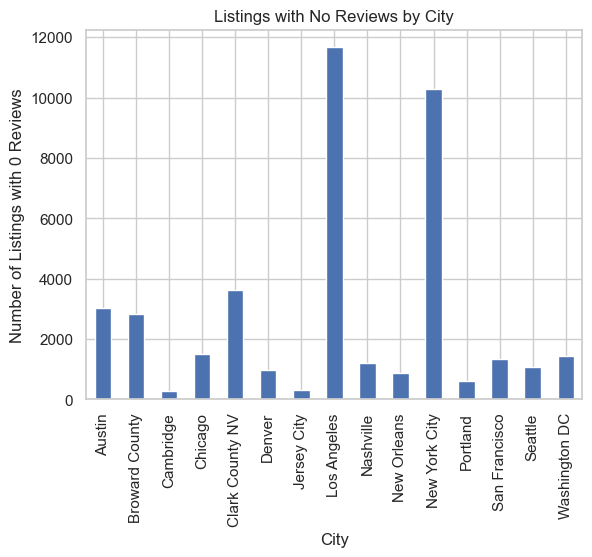

In [75]:
# Filter rows where number_of_reviews is 0
filtered_df = clean_df[clean_df['number_of_reviews'] == 0]

# Group by 'city' and count the number of occurrences
city_counts = filtered_df.groupby('city').size()

city_counts.plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Number of Listings with 0 Reviews')
plt.title('Listings with No Reviews by City')
plt.xticks(rotation=90)
plt.show()

### EDA on Amenties Count for All Cities

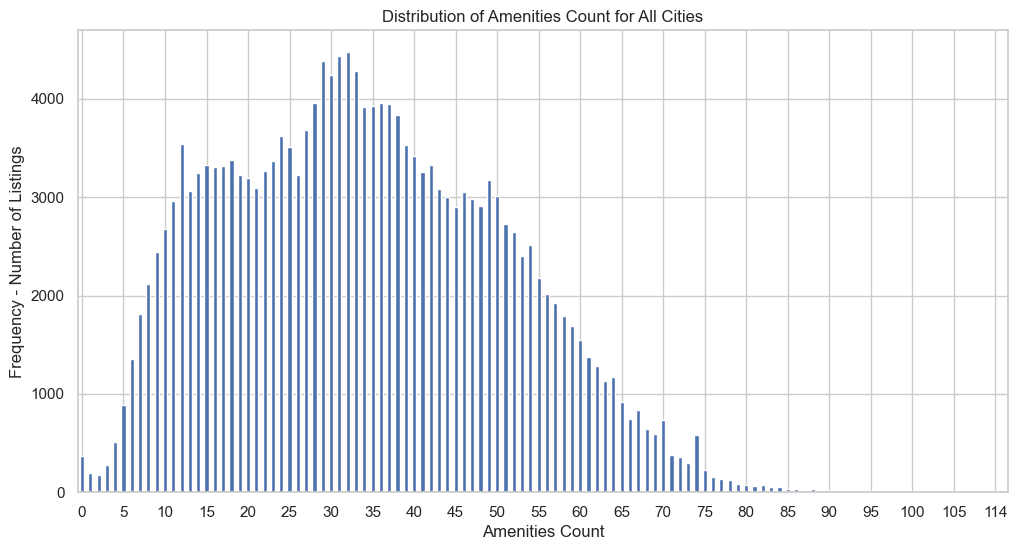

In [76]:
# Count of each amenities_count value
amenities_count_distribution = clean_df['amenities_count'].value_counts().sort_index()

plt.figure(figsize=(12, 6)) 
amenities_count_distribution.plot(kind='bar')
plt.title('Distribution of Amenities Count for All Cities')
plt.xlabel('Amenities Count')
plt.ylabel('Frequency - Number of Listings')

plt.xticks(rotation=0)  
tick_spacing = 5  
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(tick_spacing))

plt.show()

#### Boxplot on Amenties Count for Each City

We see that the median number of amenities for every city is roughly similar.

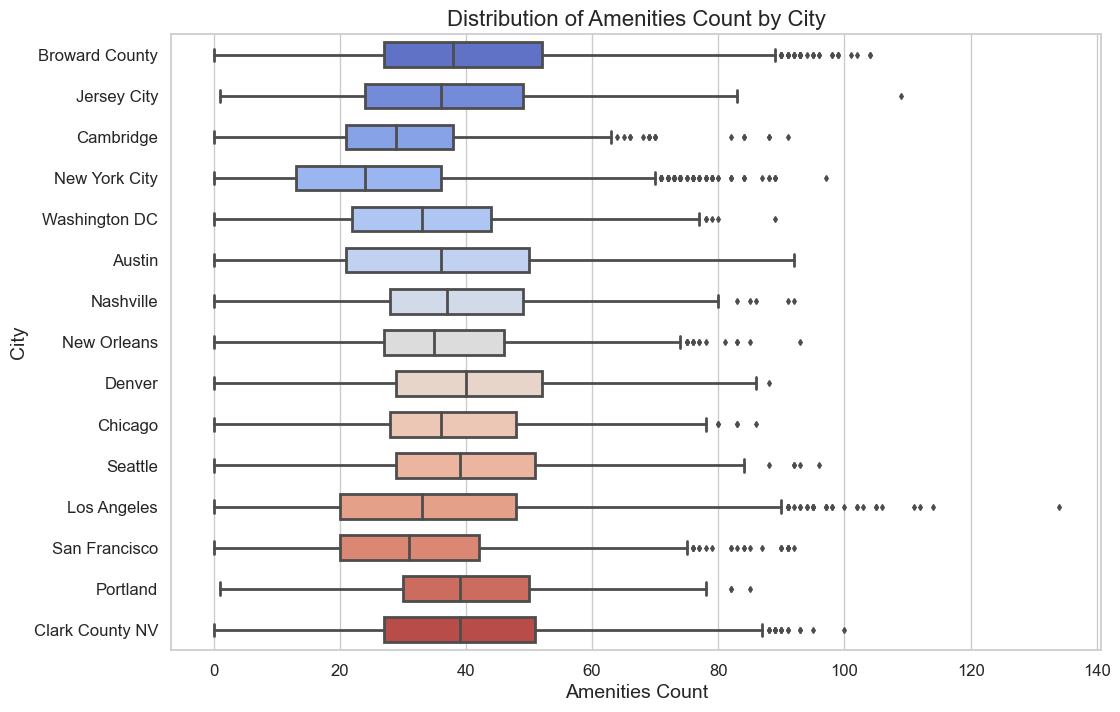

In [77]:
sns.set_style("whitegrid")

plt.figure(figsize=(12, 8))
sns.boxplot(x='amenities_count', y='city', data=clean_df,
            palette="coolwarm", 
            width=0.6,  
            linewidth=2, 
            fliersize=3, 
            )

plt.title('Distribution of Amenities Count by City', fontsize=16)
plt.xlabel('Amenities Count', fontsize=14)
plt.ylabel('City', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


### Frequency Count EDA on Specific Property Information

EDA is done for the following property information:
* accomodates
* bedrooms
* beds
* num_bath

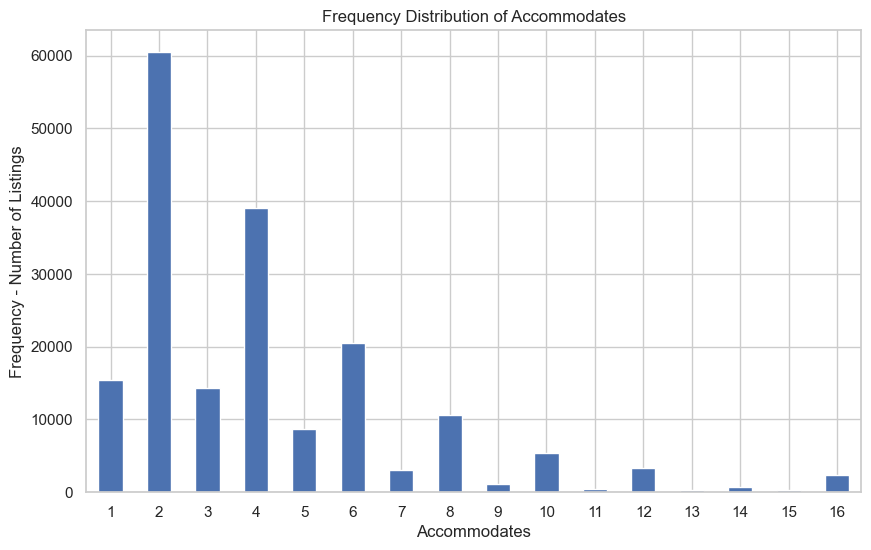

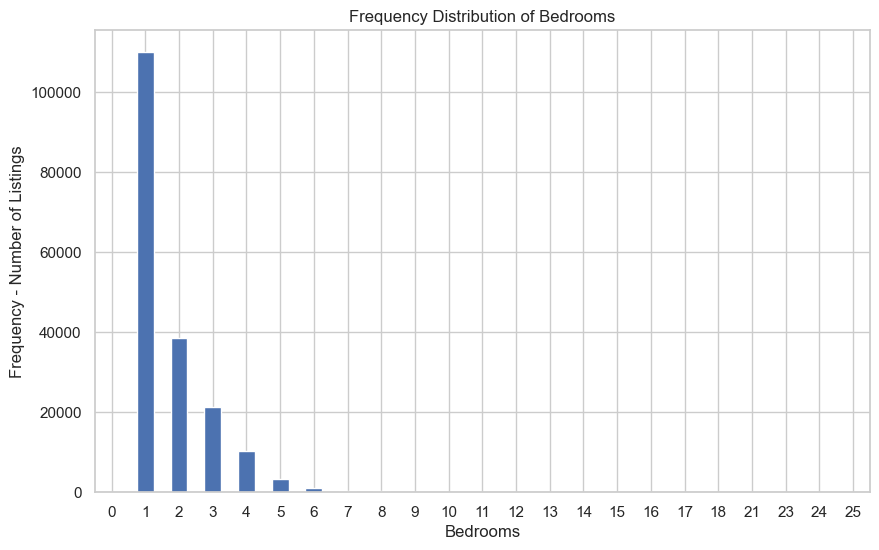

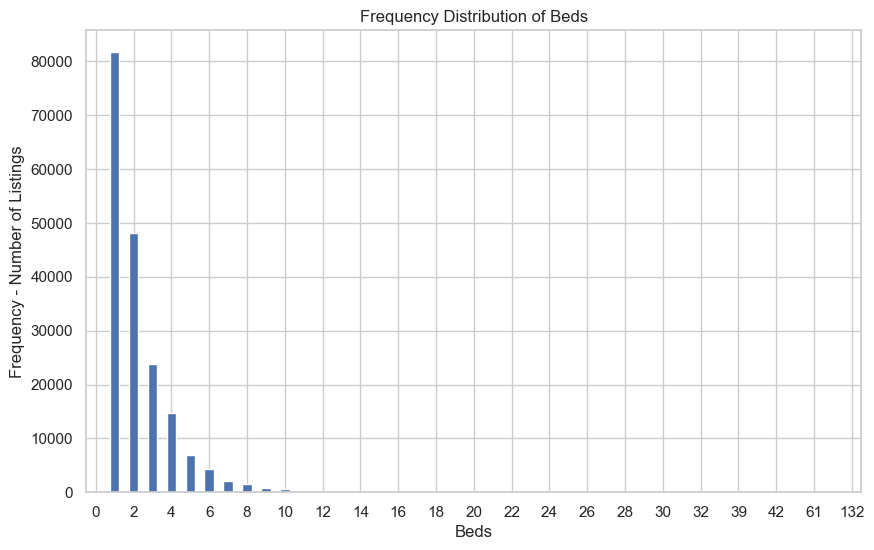

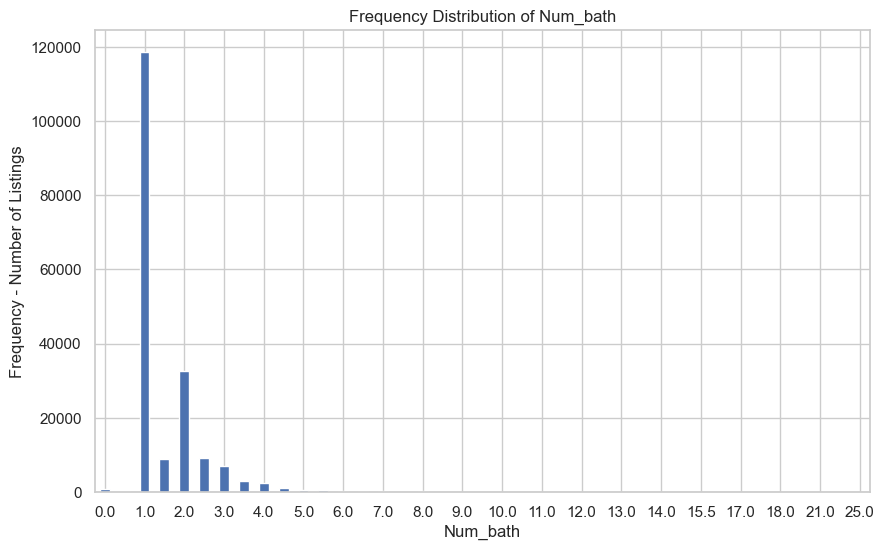

In [78]:

columns = ['accommodates', 'bedrooms']

for column in columns:
    plt.figure(figsize=(10, 6))
    value_counts_sorted_index = clean_df[column].value_counts().sort_index()
    value_counts_sorted_index.plot(kind='bar')
    plt.title(f'Frequency Distribution of {column.capitalize()}')
    plt.xlabel(column.capitalize())
    plt.ylabel('Frequency - Number of Listings')
    plt.xticks(rotation=0)
    
    plt.show()
    

columns = ['beds', 'num_bath']
for column in columns:
    plt.figure(figsize=(10, 6))
    value_counts_sorted_index = clean_df[column].value_counts().sort_index()
    value_counts_sorted_index.plot(kind='bar')
    plt.title(f'Frequency Distribution of {column.capitalize()}')
    plt.xlabel(column.capitalize())
    plt.ylabel('Frequency - Number of Listings')
    plt.xticks(rotation=0)
    tick_spacing = 2
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(tick_spacing))
    plt.show()

In [79]:
# Look at the specific stats for certain columns to get a better understanding of the data
selected_columns = ['accommodates', 'beds', 'num_bath', 'bedrooms']
stats_selected_cols = clean_df[selected_columns].describe()

stats_selected_cols


,accommodates,beds,num_bath,bedrooms
count,185918.000000,185918.000000,185918.000000,185918.000000
mean,4.149001,2.298008,1.503182,1.744048
std,2.932396,1.951242,0.941697,1.168672
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000
50%,4.000000,2.000000,1.000000,1.000000
75%,6.000000,3.000000,2.000000,2.000000
max,16.000000,132.000000,25.000000,25.000000


#### Boxplot on the Specific Listing Information to Visualize Descriptive Stats

Creating a boxplot to visualize the descriptive stats seen above and get a better idea of outliers. We see that each of these property features have outliers.

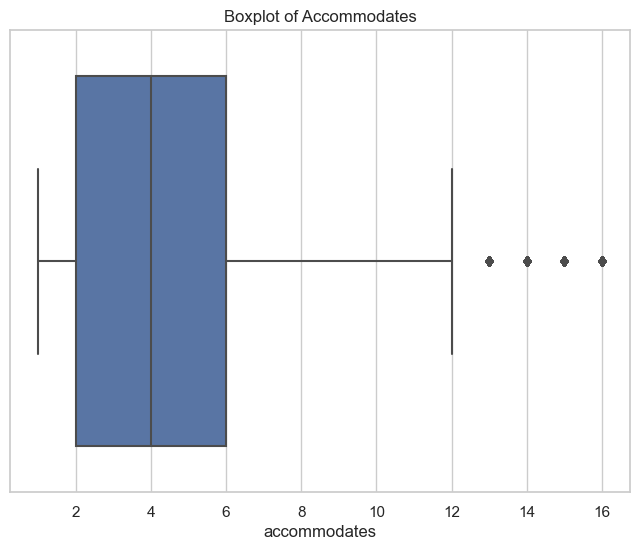

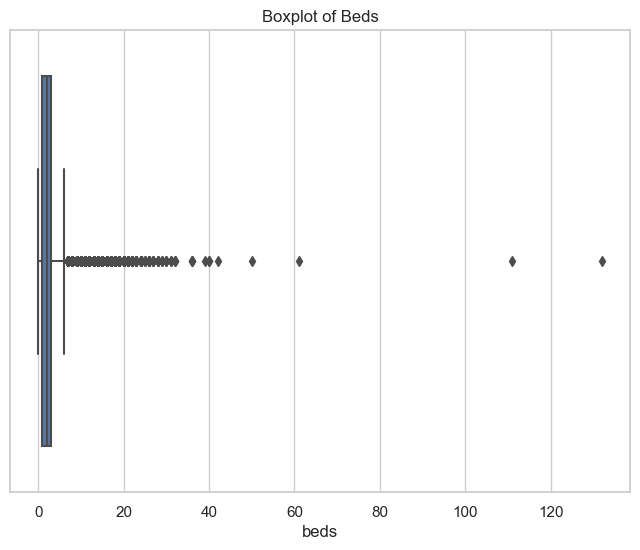

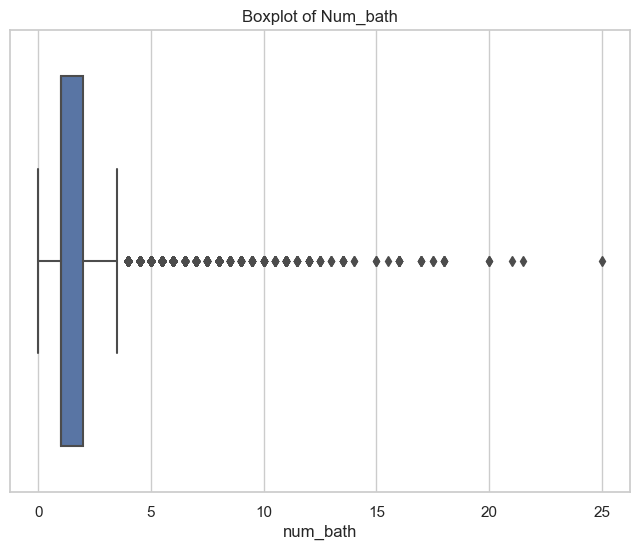

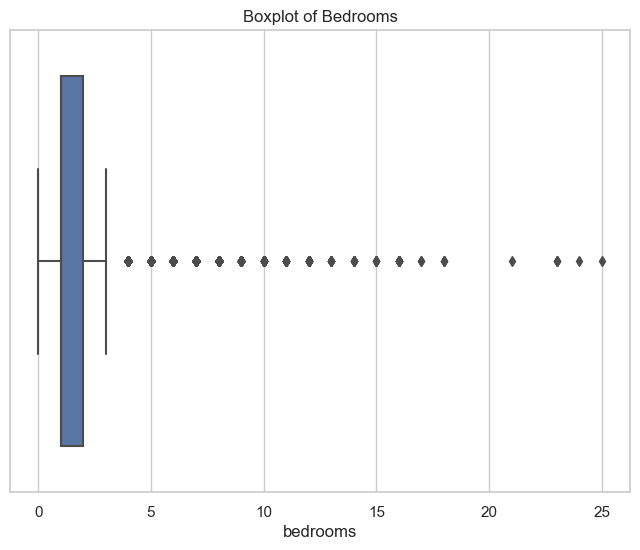

In [80]:
columns = ['accommodates', 'beds', 'num_bath', 'bedrooms']

sns.set(style="whitegrid")

for column in columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=clean_df[column])
    plt.title(f'Boxplot of {column.capitalize()}')
    plt.show()

#### Identify the outliers for the specific property information

We want to identify the outliers of each of the specific property information to see how many total outliers are there for each type of property information and understand what are the distribution of outliers.

In [81]:
# Checking the specific columns for outliers
columns = ['accommodates', 'beds', 'num_bath', 'bedrooms']

# Dictionary to hold DataFrames of outliers for each column
outlier_dfs = {}

for column in columns:
    Q1 = clean_df[column].quantile(0.25)
    Q3 = clean_df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter values outside of the IQR - which makes it an outlier
    mask = (clean_df[column] < lower_bound) | (clean_df[column] > upper_bound)
    outliers = clean_df[mask]
    
    # Store if outliers
    if not outliers.empty:
        outlier_dfs[column] = outliers[[column]]

for column, df in outlier_dfs.items():
    print(f"Outliers in {column}:\n{df}\n")

Outliers in accommodates:
        accommodates
12                16
39                13
120               16
148               16
182               16
...              ...
185764            16
185766            16
185792            16
185846            16
185857            16

[3606 rows x 1 columns]

Outliers in beds:
        beds
12        12
39         7
120       12
123        7
148        9
...      ...
185764     8
185766     8
185857    10
185867     7
185890     8

[6348 rows x 1 columns]

Outliers in num_bath:
        num_bath
12           4.0
49           4.0
126          4.5
239          4.0
254          4.0
...          ...
185764       4.0
185766       4.0
185814       4.0
185890       4.0
185916       4.0

[5426 rows x 1 columns]

Outliers in bedrooms:
        bedrooms
2              4
12             6
17             4
39             4
42             4
...          ...
185887         4
185890         5
185903         4
185910         4
185917         5

[15752 rows x 1 c

#### Unique outlier values from the above dataframes

We see that accommodates only has 4 unique types, but these 4 types equate to 3606 rows of data.

In [82]:
# Seeing what are the unique outlier values from the above dataframes
for column, df in outlier_dfs.items():
    unique_values = df[column].unique()
    print(f"Unique outliers in {column}: {unique_values}\n")

Unique outliers in accommodates: [16 13 14 15]

Unique outliers in beds: [ 12   7   9   8  11  10  17  14  15  19  13  16  18  20  21  42  22  36
  39  61 132  26  24  23  25  32  31  27  30  40 111  29  28  50]

Unique outliers in num_bath: [ 4.   4.5  5.5  6.5  5.   6.  12.   7.   8.   9.5  9.  11.5  7.5 20.
  8.5 11.  10.  15.5 15.  10.5 17.  14.  16.  12.5 13.5 18.  17.5 25.
 21.5 21.  13. ]

Unique outliers in bedrooms: [ 4  6  5  8  7 11  9 21 10 12 16 14 15 13 23 18 17 25 24]



### Frequency EDA on Host Listings Count

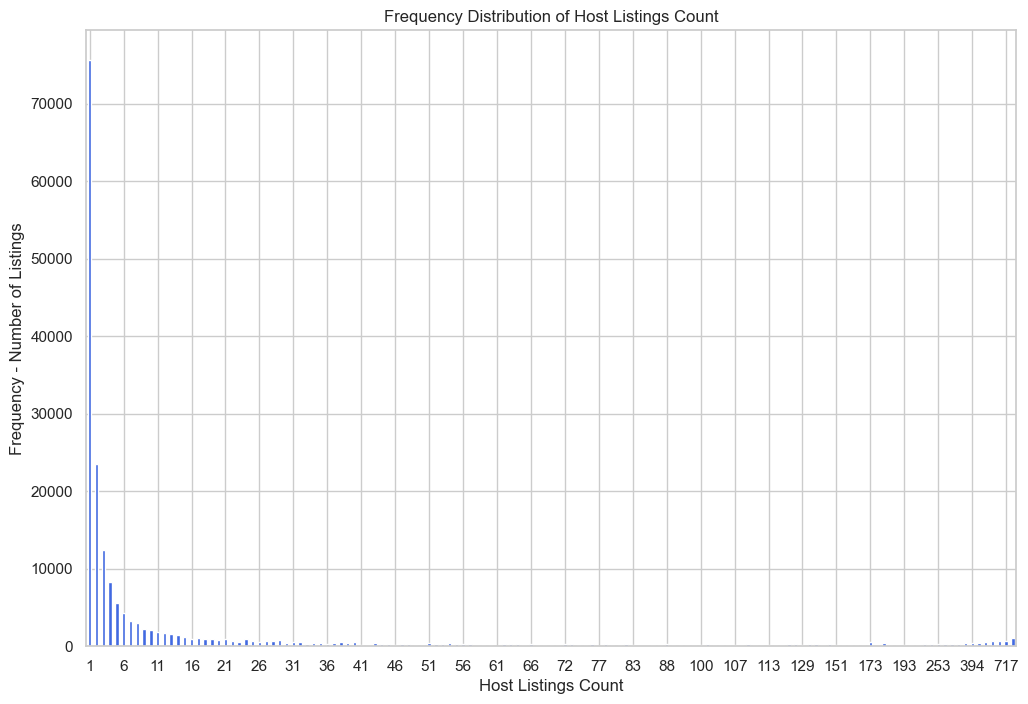

In [83]:
plt.figure(figsize=(12, 8))
value_counts_sorted_index = clean_df['calculated_host_listings_count'].value_counts().sort_index()
value_counts_sorted_index.plot(kind='bar', color='royalblue')
plt.title('Frequency Distribution of Host Listings Count')
plt.xlabel('Host Listings Count')
plt.ylabel('Frequency - Number of Listings')
plt.xticks(rotation=0)
tick_spacing = 5
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(tick_spacing))    
plt.show()

### Number of Listings Per City EDA

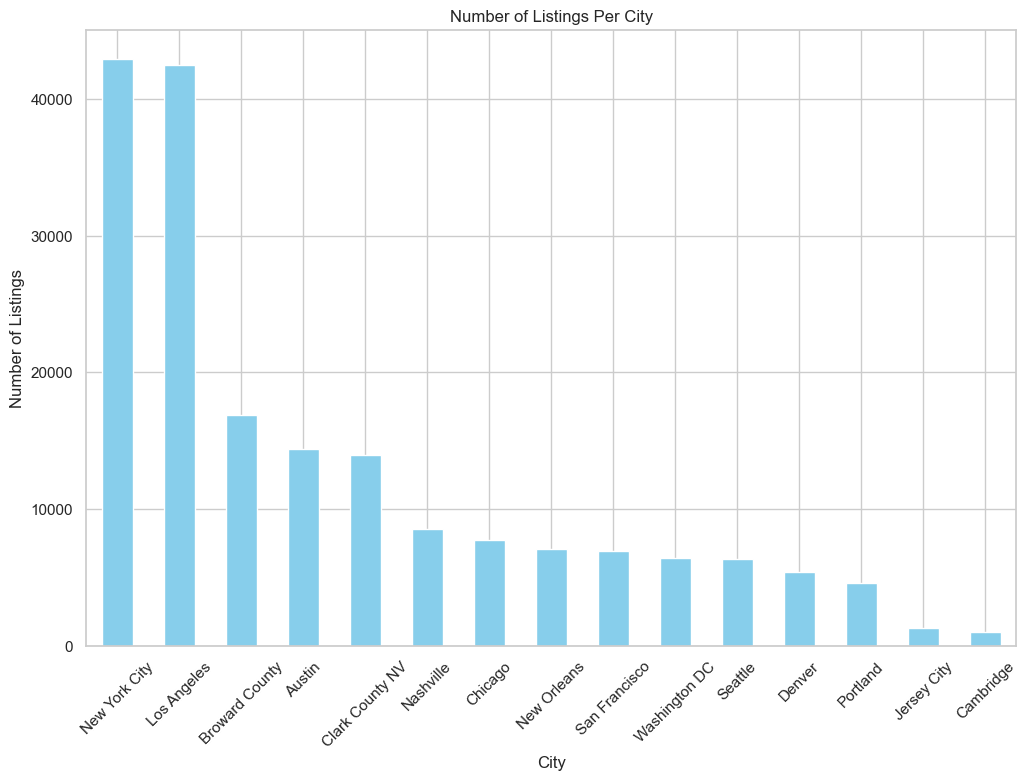

In [84]:
# Group by 'city' and count the number of listings in each city
city_counts = clean_df.groupby('city').size().sort_values(ascending=True)

# Group by 'city' and count the number of listings in each city
city_counts = clean_df['city'].value_counts()

plt.figure(figsize=(12, 8))
city_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Listings Per City')
plt.xlabel('City')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.show()